# Multivariate Forecasting Long Sequence Time Series with Autoformer

This notebook outlines the application of [Autoformer](https://arxiv.org/abs/2106.13008), a recently-proposed model for time series forecasting, to a collection of hourly data
from California Department of Transportation, which describes the road occupancy rates measured
by 862 different sensors on San Francisco Bay area freeways. 

This demo uses an implementation of NHTIS from the neuralforecast package. [neuralforecast](https://github.com/jdb78/pytorch-forecasting) is a package/repository that provides implementations of several state-of-the-art deep learning-based forecasting models, namely [Autoformer](https://arxiv.org/abs/2106.13008), [Informer](https://arxiv.org/abs/2012.07436), [NHITS](https://arxiv.org/abs/2201.12886) and [ES-RNN](https://www.sciencedirect.com/science/article/abs/pii/S0169207019301153). Similar to PyTorch Forecasting, neuralforecast is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box. 

**Note:** neuralforecast is a relatively new package that has been gaining traction because, unlike more mature packages, it supports recent state-of-the-art methods like NHITS and Autoformer. That being said, the documentation is sparse and the package is not as mature as others we have used in other demos ([PyTorch Forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/), [Prophet](https://facebook.github.io/prophet/)). In any event, neuralforecast provides a great oppurtunity to explore bleeding edge time series forecasting methods.

## Environment Configuration and Package Imports

**Note for Colab users:** Run the following cell to install PyTorch Forecasting. After installation completes, you will likely need to restart the Colab runtime. If this is the case, a button RESTART RUNTIME will appear at the bottom of the next cell's output.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch_lightning
    !pip install neuralforecast

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl

import neuralforecast as nf
from neuralforecast.data.datasets.epf import EPF
from pytorch_lightning.callbacks import EarlyStopping
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.experiments.utils import create_datasets
from neuralforecast.data.tsdataset import IterateWindowsDataset

In [3]:
warnings.filterwarnings("ignore") # Comment out 

## Hyperparameter Definitions

In [4]:
VAL_PERC = .1
TEST_PERC = .1
N_TIME_SERIES = 862

In [5]:
mc_model = {}

mc_model['seq_len'] = 96 # Input sequence size.
mc_model['label_len'] = 96 // 2 # Label sequence size. (Input buffer length for decoder)
mc_model['pred_len'] = 96 # Prediction sequence size.
mc_model['output_attention'] = False # If true use output attention for Transformer model.
mc_model['enc_in'] = N_TIME_SERIES #  Number of encoders in data embedding layers.
mc_model['dec_in'] = N_TIME_SERIES #  Number of decoders in data embedding layers.
mc_model['d_model'] = 512 #  Number of nodes for embedding layers.
mc_model['c_out'] = N_TIME_SERIES # Number of output nodes in projection layer.
mc_model['embed'] = 'timeF' #  Type of embedding layers.
mc_model['freq'] = 'h' # Frequency for embedding layers.
mc_model['dropout'] = 0.05 # Float between (0, 1). Dropout for Transformer.
mc_model['factor'] = 1 # Factor for attention layer.
mc_model['n_heads'] = 8 #  Number of heads in attention layer.
mc_model['d_ff'] = 2_048 #  Number of inputs in encoder layers.
mc_model['moving_avg'] = 25  #  Moving average for encoder and decoder layers.
mc_model['activation'] = 'gelu' #  Activation function for encoder layer.
mc_model['e_layers'] = 2 # Number of encoder layers.
mc_model['d_layers'] = 1 # Number of decoder layers.
mc_model['loss_train'] = 'MAE' # Loss to optimize. An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2']. 
mc_model['loss_hypar'] = 0.5 # Hyperparameter for chosen loss.
mc_model['loss_valid'] = 'MAE'# Validation loss.An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
mc_model['learning_rate'] = 0.001 # Learning rate between (0, 1).
mc_model['lr_decay'] = 0.5 # Decreasing multiplier for the learning rate.
mc_model['weight_decay'] = 0. # L2 penalty for optimizer.
mc_model['lr_decay_step_size'] = 2 # Steps between each learning rate decay.
mc_model['random_seed'] = 1 # random_seed for pseudo random pytorch initializer and numpy random generator.

# Dataset parameters
mc_data = {}
mc_data['mode'] = 'iterate_windows'
mc_data['n_time_in'] = mc_model['seq_len'] # Input sequence length
mc_data['n_time_out'] = mc_model['pred_len'] # Prediction sequence length
mc_data['batch_size'] = 1 # Batch size 
mc_data['normalizer_y'] = None 
mc_data['normalizer_x'] = None
mc_data['max_epochs'] = 1 # Maximum number of training epochs
mc_data['max_steps'] = None # maximum number of training steps
mc_data['early_stop_patience'] = 20 #Number of consecutive violations of early stopping criteria to end training

## Load Data
We start by loading the data. neuralforecast provides utilities for loading a [variety of different datasets](https://nixtla.github.io/neuralforecast/data_datasets__long_horizon.html) popular in the time series forecasting domain. Conveniently, the loaded data is in the format that is expected by the model that we define in the subsequent section. In particular, we call the `load` function with an argument specifying the dataset to load three dataframes: 
- `Y_df`: (pd.DataFrame) Target time series with columns ['unique_id', 'ds', 'y']
- `X_df`: (pd.DataFrame) Exogenous time series with columns ['unique_id', 'ds', 'y']
- `S_df` (pd.DataFrame) Static exogenous variables with columns ['unique_id'] and static variables. 

The columns referenced above are defined as follows:
- `unique_id`: column used to identify which time series the dataframe row corresponds to. The number of unique values in the column is the number of time series in the dataset.
- `ds`: column used to identify the time stamp the dataframe row corresponds to. 

In this way, a combination of `unique_id` and `ds` identify a sample in  `Y_df` and `X_df`. Thus, the total number of rows they contain is the product of the unique observations in `unique_id` and `ds`. On the other hand, `S_df` contains a row for each exogneous variable-time series pairing. If no exogenous varables exist for any of the time sereis, `S_df` is `None`. 

For datasets that are not supported out of the box for the package, we must construct these dataframes ourselves with the format specified above.

In [6]:
Y_df, X_df, S_df = nf.data.datasets.long_horizon.LongHorizon.load('autoformer_data', 'TrafficL')

In [7]:
Y_df

,unique_id,ds,y
0,0,2016-07-01 02:00:00,-0.711224
1,0,2016-07-01 03:00:00,-0.672014
2,0,2016-07-01 04:00:00,-0.724294
3,0,2016-07-01 05:00:00,-0.725928
4,0,2016-07-01 06:00:00,-0.721027
...,...,...,...
15122923,OT,2018-07-01 21:00:00,0.765917
15122924,OT,2018-07-01 22:00:00,0.389237
15122925,OT,2018-07-01 23:00:00,0.172360
15122926,OT,2018-07-02 00:00:00,-0.090175


In [8]:
X_df

,unique_id,ds,ex_1,ex_2,ex_3,ex_4
0,0,2016-07-01 02:00:00,-0.413043,0.166667,-0.500000,-0.00137
1,0,2016-07-01 03:00:00,-0.369565,0.166667,-0.500000,-0.00137
2,0,2016-07-01 04:00:00,-0.326087,0.166667,-0.500000,-0.00137
3,0,2016-07-01 05:00:00,-0.282609,0.166667,-0.500000,-0.00137
4,0,2016-07-01 06:00:00,-0.239130,0.166667,-0.500000,-0.00137
...,...,...,...,...,...,...
15122923,OT,2018-07-01 21:00:00,0.413043,0.500000,-0.500000,-0.00411
15122924,OT,2018-07-01 22:00:00,0.456522,0.500000,-0.500000,-0.00411
15122925,OT,2018-07-01 23:00:00,0.500000,0.500000,-0.500000,-0.00411
15122926,OT,2018-07-02 00:00:00,-0.500000,-0.500000,-0.466667,-0.00137


In [9]:
S_df

In [10]:
Y_df['ds'] = pd.to_datetime(Y_df['ds']) # Convert ds column to datetime format
X_df['ds'] = pd.to_datetime(X_df['ds']) # Convert ds column to datetime format
f_cols = X_df.drop(columns=['unique_id', 'ds']).columns.to_list()

## Data Splitting

The data is split sequentially into train, validation and test based on `VAL_PERC` and `TEST_PERC` global variables. We will withhold the last `TEST_PERC` of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

The neuralforecast package's function [create_datasets](https://nixtla.github.io/neuralforecast/experiments__utils.html#create_datasets) allows us to generate a [TSDataset](https://nixtla.github.io/neuralforecast/data__tsdataset.html) for the train, validation and test sets by passing `Y_df`, `X_df` and `S_df` that we defined above. Additionally, we specify the amount of time steps we want in the validation and test datasets, `ds_in_val` and `ds_in_test`. 


In [11]:
n_ds = Y_df["ds"].nunique()
n_val = int(VAL_PERC * n_ds)
n_test = int(TEST_PERC * n_ds)

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc_data,
                                                                     S_df=None, 
                                                                     Y_df=Y_df, X_df=X_df,
                                                                     f_cols=f_cols,
                                                                     ds_in_val=n_val,
                                                                     ds_in_test=n_test)



INFO:root:Train Validation splits

INFO:root:                             ds                    
                            min                 max
sample_mask                                        
0           2018-02-05 22:00:00 2018-07-02 01:00:00
1           2016-07-01 02:00:00 2018-02-05 21:00:00
INFO:root:
Total data 			15122928 time stamps 
Available percentage=100.0, 	15122928 time stamps 
Insample  percentage=80.0, 	12099032 time stamps 
Outsample percentage=20.0, 	3023896 time stamps 

INFO:root:Train Validation splits

INFO:root:                             ds                    
                            min                 max
sample_mask                                        
0           2016-07-01 02:00:00 2018-07-02 01:00:00
1           2018-02-05 22:00:00 2018-04-19 23:00:00
INFO:root:
Total data 			15122928 time stamps 
Available percentage=100.0, 	15122928 time stamps 
Insample  percentage=10.0, 	1511948 time stamps 
Outsample percentage=90.0, 	13610980 time sta

## Defining Dataloader
The next step is to define a PyTorch dataloader by passing a dataset, batch size and other paraneters that inform how each batch of data is loaded. 

In [12]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=int(mc_data['batch_size']),
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=int(mc_data['batch_size']),
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=int(mc_data['batch_size']),
                         shuffle=False)

## Model

###  Autoformer Overview

Autoformer is a tranformer architecture for LSTF that aims to surmount the quadratic complexity of the attention mechanism and enhance prediction accuracy. In doing so, the Autoformer proposes two novel components, the Series Deocmposition Block and the Autocorrelation Block, that function as follows:

- **Series Decomposition Block:** Block that decomposes series into seasonal and trend-cyclical components. Used throughout the architecture to allow for the progressive decomposition of complex time series. 
- **Autocorrelation Block:** Self attention mechanism that conducts dependecy discovery and representation aggregation at the subseries level. Assuming that sub-series at the same phase position exhibit similar temporal processes, the Autocorrelation block construct series level connections based on the process similarity which is derived using series periodicity. 

At the top level, autoformer consists of an encoder and a decoder, each of which is composed sets of Auto-Correlation, Series Decomposition and Feed Forward Blocks with residual connections. 

<p align="center">
<img width="800" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/149202576-720856f7-c827-4e3d-85d7-0053328e1c8d.png">  
</p>


## Model Definition
Using the neuralforecast package, an Autoformer model can be initialized using the `Autoformer` class. This returns a Pytorch Lighnting model that we will subsequently train and evaluate. There is a large amount of parameters involved in the definition which are passed via a dictionary. Some of the dictionary items may that may vary accross datasets include:
- `seq_len`: (int) The length of sequences input  to the encoder. 
`label_len`: (int) The length of input fed to the decoder.
- `pred_len`: (int) The length of the sequences output by the model.  
- `freq `: (string) The frequency of the observations. (hourly:`h`, daily:`d`)
- `enc_in`: (int) The number of time series input into encoder.
- `dec_in`: (int) The number of time series input into decoder.
- `c_out`: (int) The number of time series output by the model. 

For additional details in regards to the `Autoformer` class, consult the  [neuralforecast documentation](https://nixtla.github.io/neuralforecast/models_transformer__autoformer.html). Values of model hyperparameters with corresponding defintions is available above in the **Hyperparameter Defintions** section.

In [13]:
model = nf.models.transformer.autoformer.Autoformer(**mc_model)

## Training and Validation
We first define a pytorch lighting trainer which encapsulates the training process and allows us to easily implement a training and validation loop with the specified parameters. The arguments to the trainer include: 
- `max_epochs`: (Optional[int]) – Stop training once this number of epochs is reached. 
- `callbacks`: (Union[List[Callback], Callback, None]) – Add a callback or list of callbacks.

Subsequently, we can use the `fit` method of the trainer with the `net`, `train_dataloader` and `val_dataloader` to perform the training and validation loop. 

For more information regarding the `pl.Trainer` class, consult the [PyTorch Lightning documentation](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer.validate).

In [14]:
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=1e-4, 
                                            patience=mc_data['early_stop_patience'],
                                            verbose=False,
                                            mode="min")

trainer = pl.Trainer(max_epochs=mc_data['max_epochs'], 
                     max_steps=mc_data['max_steps'],
                     accelerator="gpu",
                     devices=1,
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=10, 
                     check_val_every_n_epoch=1,
                     log_every_n_steps=500, 
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | _Autoformer | 14.9 M
--------------------------------------
14.9 M    Trainable params
0         Non-trainable params
14.9 M    Total params
59.658    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Test

### Inference
We can obtain the predictions of the trained model on the test samples using the predict method of the trainer object. This will output a list the same length as the number of test batches. Each entry in this list (ie `outputs[0]`) is a list itself where the first item (ie `outputs[0][0]`) is the ground truth and the second item (ie `outputs[0][1]`) is the prediction. Each of these items a 3D tensor of shape: batch size by sequenze length by number of time series.

In [15]:
model.return_decomposition = False
outputs = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 13845it [00:00, ?it/s]

In [16]:
input_list = []
for d in test_loader:
    Y = d["Y"].squeeze()
    inp = Y[:, :mc_model['seq_len']].squeeze()
    input_list.append(inp)

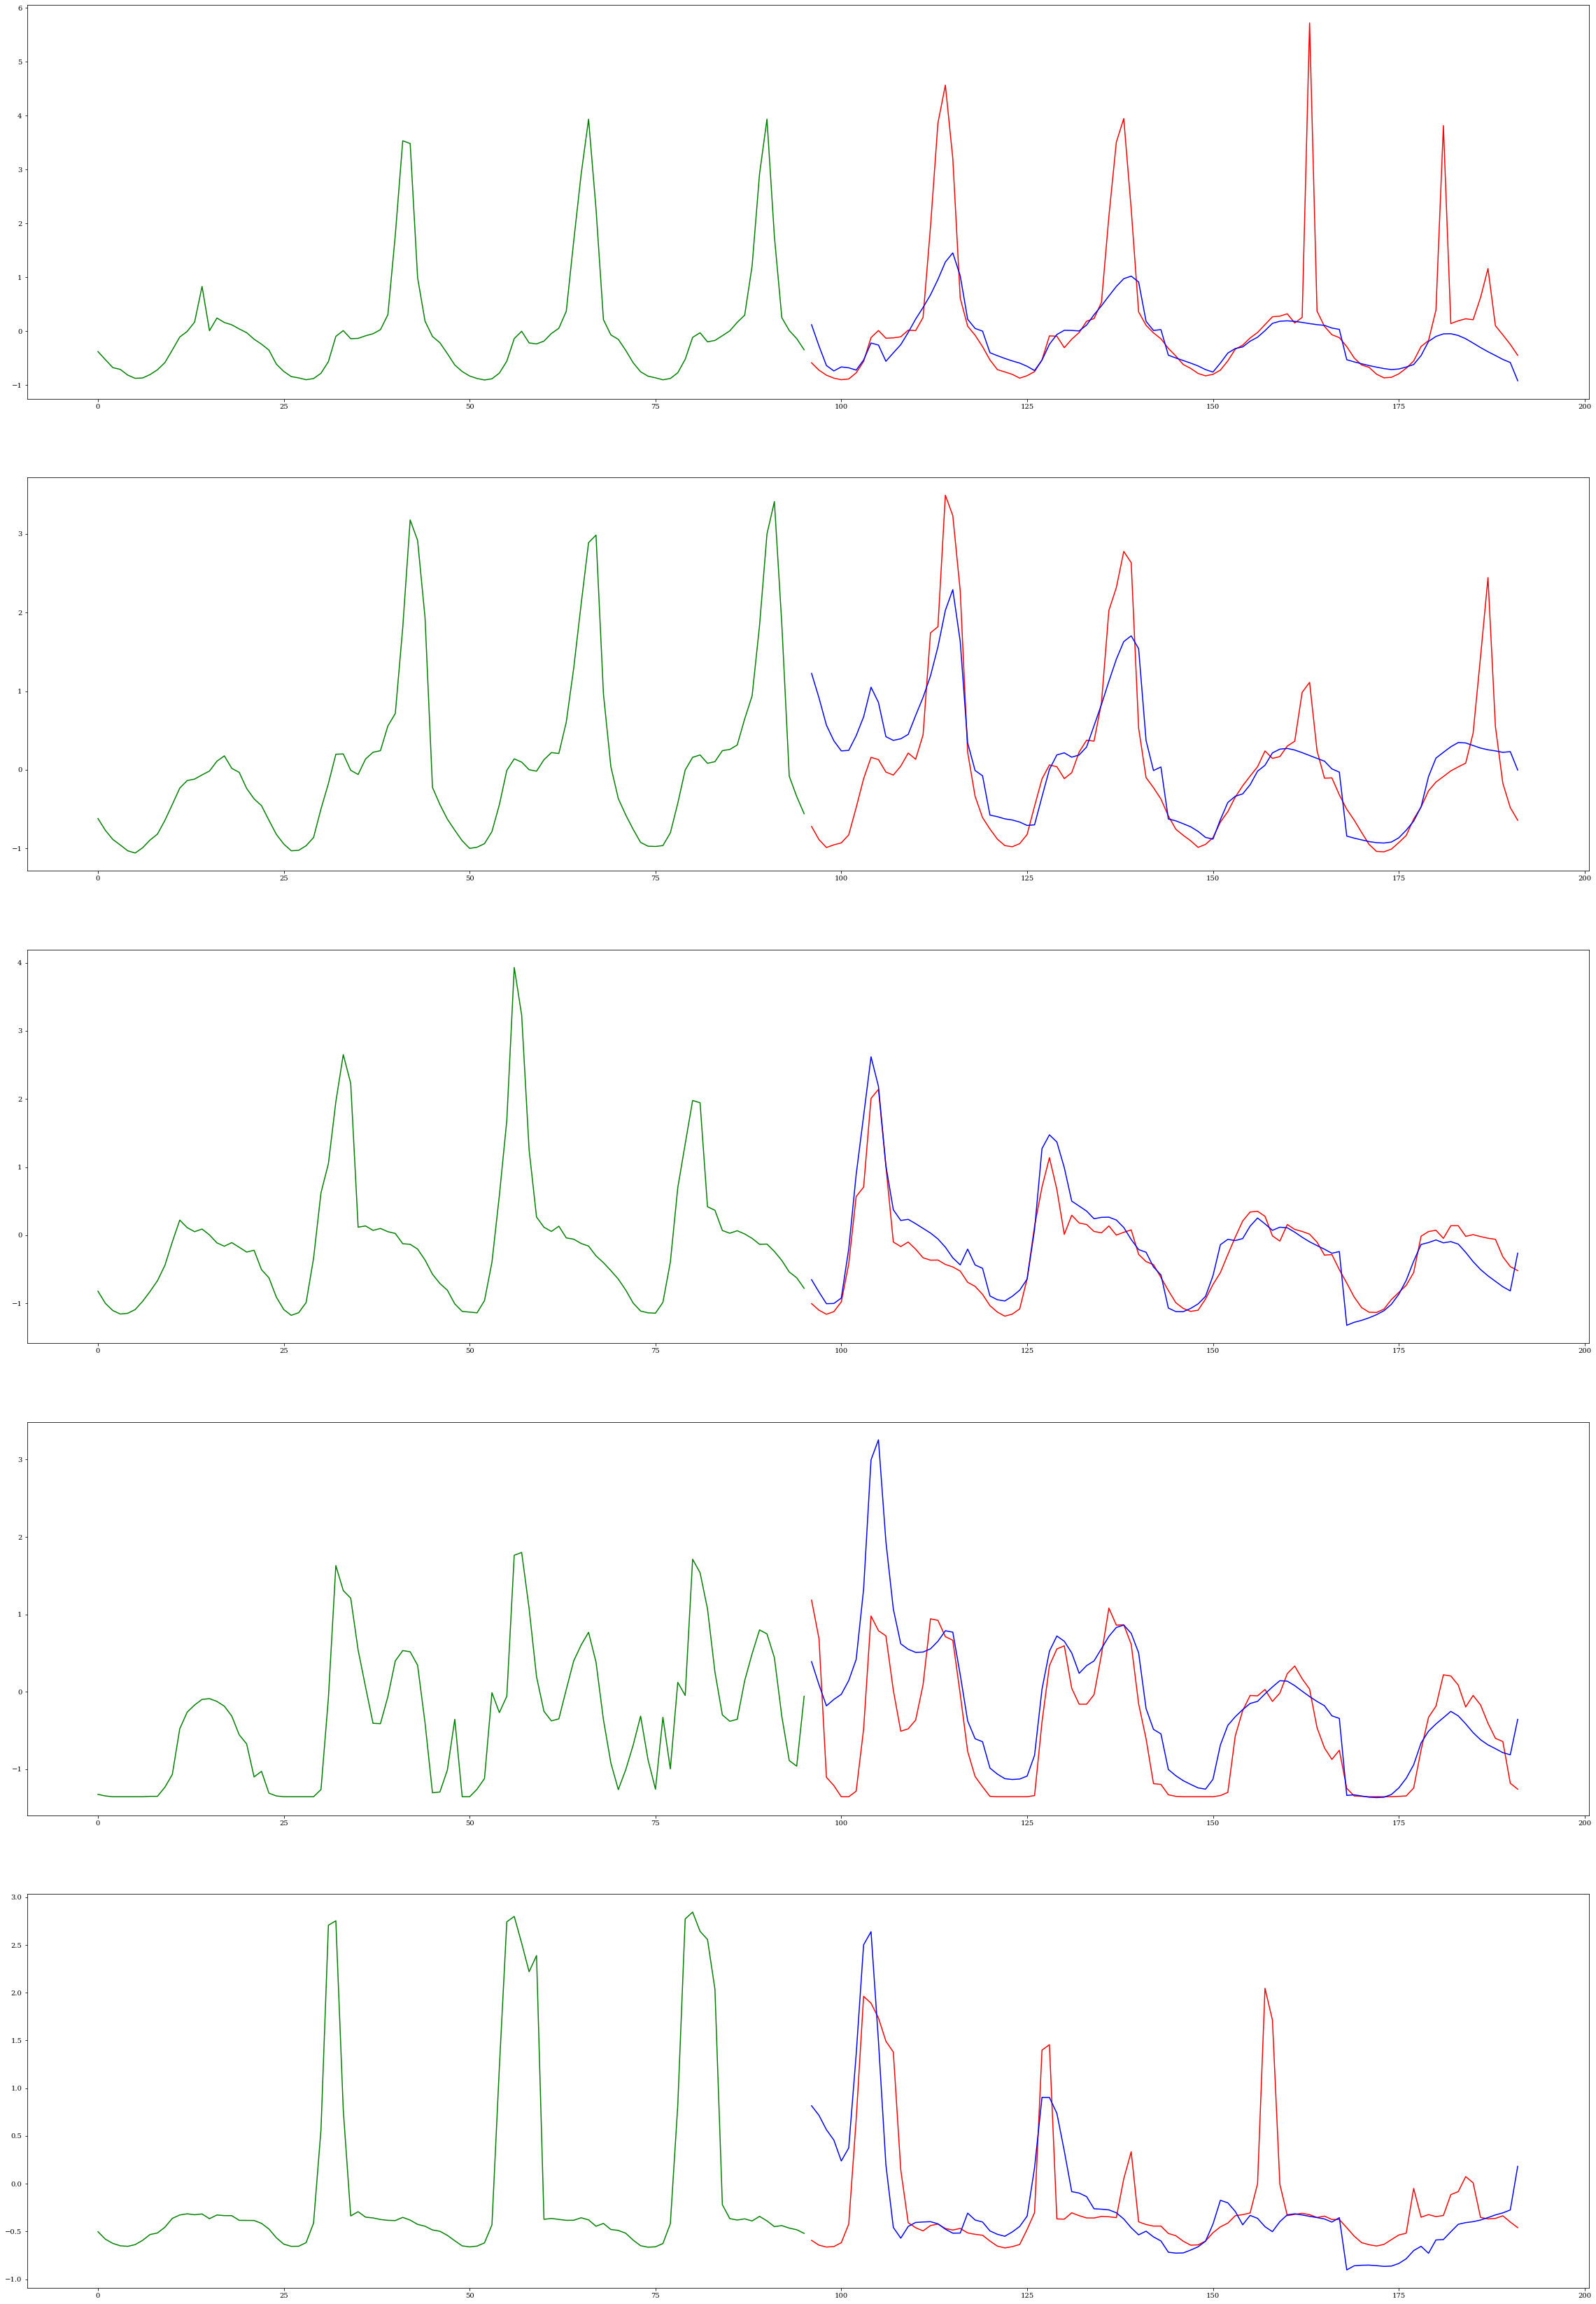

In [17]:
n_samples = 5
ss_indices = np.random.choice(N_TIME_SERIES, n_samples, replace=False).tolist()

f, axarr = plt.subplots(5, 1, figsize=(40, 60))
for i, ss_ind in enumerate(ss_indices):
    inp = input_list[0][ss_ind, :].cpu().numpy()

    out1 = outputs[0][0].squeeze()[:, ss_ind].cpu().numpy()
    out2 = outputs[0][1].squeeze()[:, ss_ind].cpu().numpy()

    inp_index = [j for j in range(mc_model['seq_len'])]
    out_index = [j for j in range(mc_model['seq_len'], mc_model['seq_len'] + mc_model['pred_len'])]

    axarr[i].plot(inp_index, inp, c="green")
    axarr[i].plot(out_index, out1, c="red")
    axarr[i].plot(out_index, out2, c="blue")

### Quantitative Resutls
To assess the performance of Autoformer on the dataset, we calculate its performance on the test set using a set of metrics that are commonly used in time series forecasting. The metrics include Mean Absolute Error (MAE) and Mean Squared Error (MSE).

In [ ]:
# Aggregate list of ground truth and prediction series in to lists
true_list = [output[0].squeeze().transpose(1, 0) for output in outputs]
pred_list = [output[1].squeeze().transpose(1, 0) for output in outputs]

# Stack lists into tensors along the sample/batch dimension
trues = torch.concat(true_list, dim=0)
preds = torch.concat(pred_list, dim=0)

# Calculate Losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")